In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as an
import scanpy as sc
import pandas as pd

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


In [3]:
#Set path
data_path = '../SourceData/Figure3/'

# Plot waveforms (Figure3c)

CM_EC channels: 31
CM channels: 30


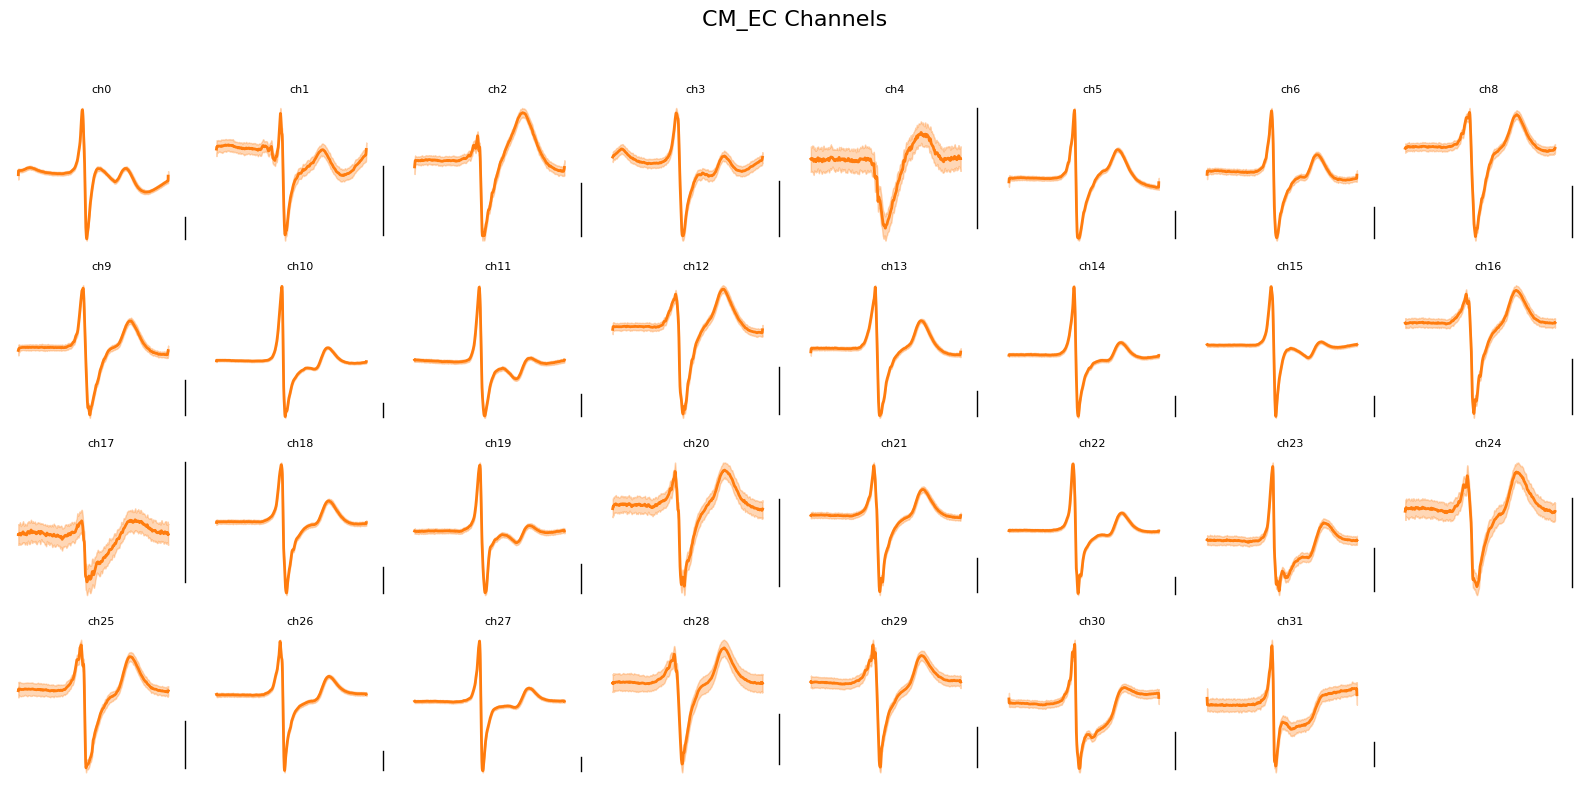

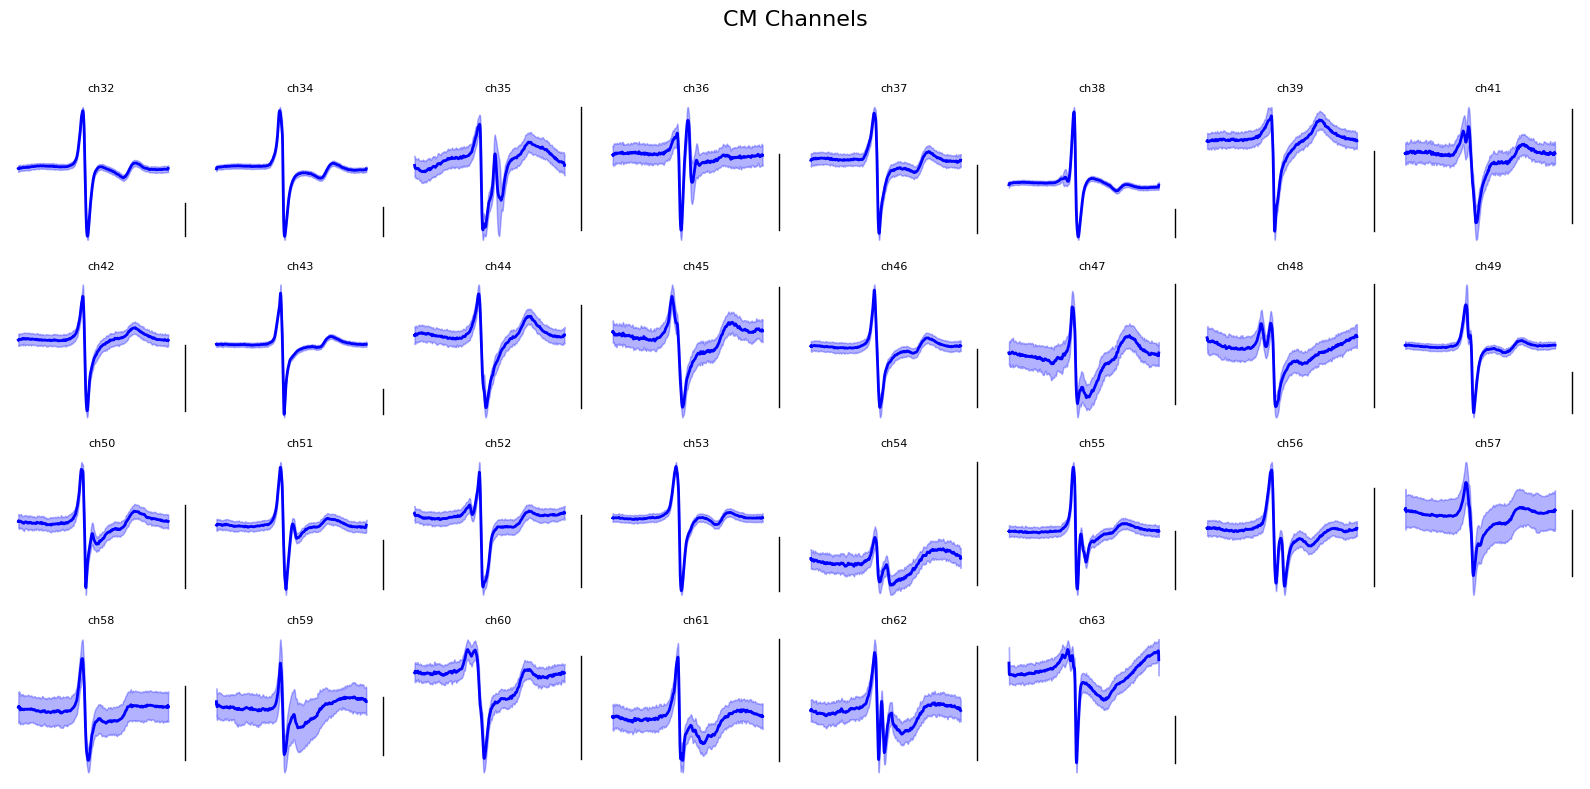

In [4]:
# Load the saved .npz file (run this first to load your data)
loaded_data = np.load(data_path + "Figure3c_waveforms.npz", allow_pickle=True)

# Extract stored arrays
mean_waveforms = loaded_data["mean_waveforms"].item()  # Convert back to dictionary
std_waveforms = loaded_data["std_waveforms"].item()    # Convert back to dictionary
channels = loaded_data["channels"]
regions = loaded_data["regions"]

# Create lists to store channels by region
cm_ec_channels = []
cm_channels = []

# Sort channels by region
for i, (channel, region) in enumerate(regions):
    if region == "CM_EC":
        cm_ec_channels.append(channel)
    elif region == "CM":
        cm_channels.append(channel)

# Print summary
print(f"CM_EC channels: {len(cm_ec_channels)}")
print(f"CM channels: {len(cm_channels)}")

# Define grid layout
a = 4  # number of rows
b = 8  # number of columns

# Plot CM_EC channels
c = 1  # initialize plot counter
fig = plt.figure(figsize=(16, 8))
plt.suptitle("CM_EC Channels", fontsize=16)

for ch in cm_ec_channels:
    if c > a*b:  # Skip if we've filled the grid
        break
        
    plt.subplot(a, b, c)
    plt.title(f'{ch}', fontsize=8)
    
    # Plot with orange color for CM_EC
    plt.plot(mean_waveforms[ch], color='#ff7c0e', linewidth=2)
    plt.fill_between(np.arange(len(mean_waveforms[ch])), 
                     mean_waveforms[ch] - std_waveforms[ch], 
                     mean_waveforms[ch] + std_waveforms[ch], 
                     color='#ff7c0e', alpha=0.3)
    
    # Format axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Add vertical scale bar
    scale_y = [np.min(mean_waveforms[ch]), np.min(mean_waveforms[ch]) + 20]
    scale_x = [10000, 10000]  # Adjust the x position of the scale bar
    ax.plot(scale_x, scale_y, 'k-', linewidth=1)
    
    c = c + 1

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the title
plt.show()

# Plot CM channels
c = 1  # reset plot counter
fig = plt.figure(figsize=(16, 8))
plt.suptitle("CM Channels", fontsize=16)

for ch in cm_channels:
    if c > a*b:  # Skip if we've filled the grid
        break
        
    plt.subplot(a, b, c)
    plt.title(f'{ch}', fontsize=8)
    
    # Plot with blue color for CM
    plt.plot(mean_waveforms[ch], color='blue', linewidth=2)
    plt.fill_between(np.arange(len(mean_waveforms[ch])), 
                     mean_waveforms[ch] - std_waveforms[ch], 
                     mean_waveforms[ch] + std_waveforms[ch], 
                     color='blue', alpha=0.3)
    
    # Format axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Add vertical scale bar
    scale_y = [np.min(mean_waveforms[ch]), np.min(mean_waveforms[ch]) + 20]
    scale_x = [10000, 10000]  # Adjust the x position of the scale bar
    ax.plot(scale_x, scale_y, 'k-', linewidth=1)
    
    c = c + 1

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the title
plt.show()

# Load Anndata

In [5]:
waveform_mean_denoised = sc.read_h5ad(data_path + 'Figure3_waveforms_mean_denoised.h5ad')
waveform_mean_denoised.obs_names_make_unique()

# UMAP (Figure 3d)

In [6]:
sc.tl.pca(waveform_mean_denoised, svd_solver='arpack')
sc.pp.neighbors(waveform_mean_denoised)
sc.tl.umap(waveform_mean_denoised)

waveform_mean_denoised.obsm['X_umap'].shape

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(61, 2)

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


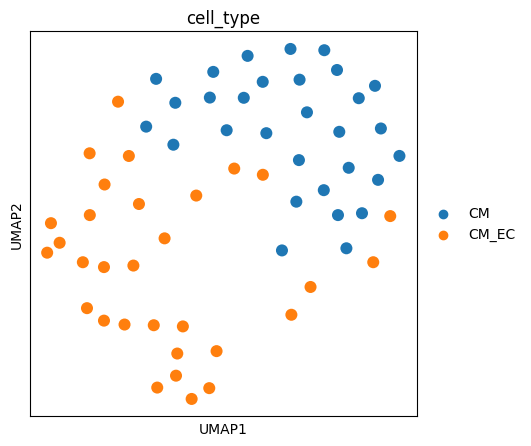

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

# Generate UMAP plot with return_fig=True to capture the figure object
sc.pl.umap(waveform_mean_denoised, color=['cell_type'], size=300, ax=ax, show=False)
plt.show()


# Read Gene Dataset

In [8]:
# All transcriptomic datset
st_ad = sc.read_h5ad(data_path + 'st_ad_all.h5ad')

# Transcriptomic dataset of electrophysiologically recorded cells
st_ad_recorded = sc.read_h5ad(data_path + 'st_ad_recorded.h5ad')

cell_type_dict = {
    'Unidentified': '#1f77b4',  # Blue
    'CM_s1': '#ff7f0e',          # Orange
    'CM_s2': '#2ca02c',          # Green
    'CM_s3': '#d62728',          # Red
    'Endothelial': '#9467bd',    # Purple
    'Fibroblast': '#8c564b'      # Brown
}

niche_type_dict = {
    'Niche_1': '#17becf',  
    'Niche_2': '#bcbd22', 
    'Niche_3': '#ff9896'   
}

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


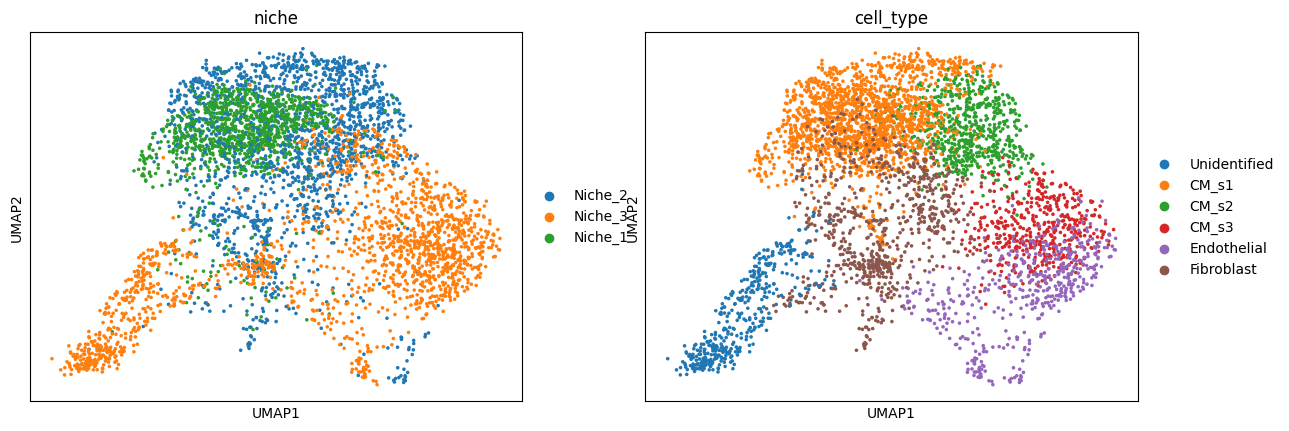

In [9]:
sc.pl.umap(st_ad, color=['niche', 'cell_type'])


# UMAPS (Figure 3 h,i)

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


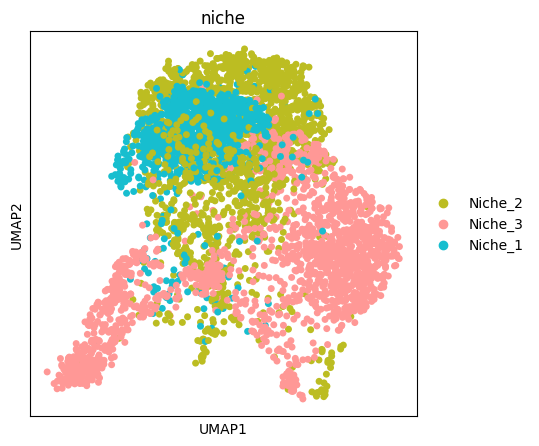

In [10]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = sc.pl.umap(st_ad, color=['niche'], s=100, palette=niche_type_dict, show=False)
    plt.show()

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


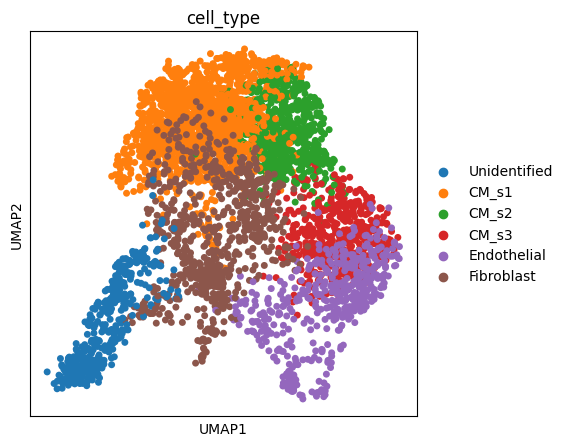

In [11]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = sc.pl.umap(st_ad, color=['cell_type'], s=100, show=False)
    plt.show()

# Niche composition (Figure 3j)

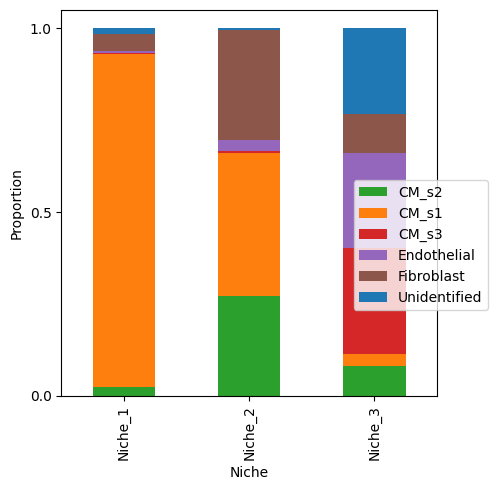

In [12]:
# Load and normalize data
cell_type_niche_composition_df = pd.read_csv(data_path + 'cell_type_niche_composition_df.csv', index_col=0)
cell_type_niche_composition_norm_df = cell_type_niche_composition_df.div(cell_type_niche_composition_df.sum(axis=1), axis=0)

# Plotting
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = cell_type_niche_composition_norm_df.plot(kind='bar', stacked=True, color=cell_type_dict)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Niche')
    
    # Set y-axis ticks to [0.0, 0.5, 1.0]
    ax.set_yticks([0.0, 0.5, 1.0])
    
    # Position legend
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center right", bbox_transform=plt.gcf().transFigure)
    
    plt.tight_layout()

    plt.show()

# CM states vs Niche (Figure 3k)

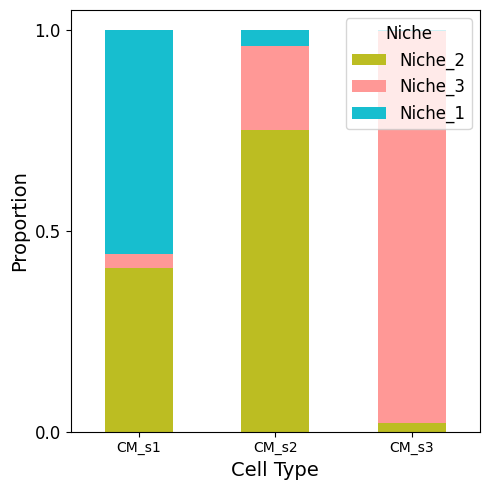

In [13]:
# Filtering the data
st_ad_electrogenic = st_ad[st_ad.obs['cell_type'].isin(['CM_s1', 'CM_s2', 'CM_s3'])]
data_i = st_ad_electrogenic

# Creating contingency table and calculating proportions
contingency_table = pd.crosstab(data_i.obs['cell_type'], data_i.obs['niche'])
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Plotting
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = proportions.plot(kind='bar', stacked=True, color=[niche_type_dict[str(i)] for i in proportions.columns])
    
    # Enhancing labels and layout
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_xlabel('Cell Type', fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=12)
    
    # Setting specific y-ticks
    ax.set_yticks([0.0, 0.5, 1.0])
    
    # Positioning and styling legend in the upper right
    ax.legend(title="Niche", loc="upper right", fontsize=12, title_fontsize=12, frameon=True)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Tissue region vs CM states (Figure 3l)

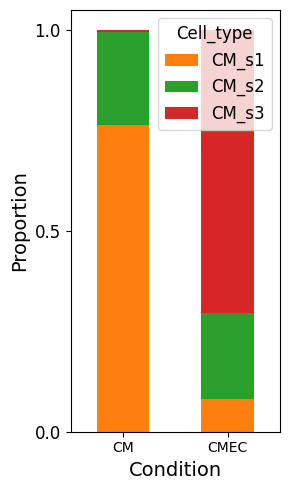

In [14]:
# Creating contingency table and calculating proportions
contingency_table = pd.crosstab(data_i.obs['condition'], data_i.obs['cell_type'])
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Plotting
with plt.rc_context({"figure.figsize": (3, 5), "figure.dpi": 100}):
    ax = proportions.plot(kind='bar', stacked=True, color=[cell_type_dict[str(i)] for i in proportions.columns])
    
    # Enhancing labels and layout
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_xlabel('Condition', fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=12)
    
    # Setting specific y-ticks
    ax.set_yticks([0.0, 0.5, 1.0])
    
    # Positioning and styling legend in the upper right
    ax.legend(title="Cell_type", loc="upper right", fontsize=12, title_fontsize=12, frameon=True)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

## Pseudotime analysis 

In [15]:
# load filtered AnnData (both have electrical recording and transcriptomic data)
sc_ad_recorded = sc.read_h5ad(data_path + 'st_ad_recorded_filtered.h5ad')

In [16]:
# Activate the pandas2ri conversion
pandas2ri.activate()

# Import necessary R packages
base = importr('base')
slingshot = importr('slingshot')

# Convert the UMAP embeddings and cluster labels to R-compatible formats
with localconverter(ro.default_converter + pandas2ri.converter):
    umap = ro.conversion.py2rpy(pd.DataFrame(sc_ad_recorded.obsm['X_umap'], index=sc_ad_recorded.obs.index))
    clusters = ro.conversion.py2rpy(pd.Series(sc_ad_recorded.obs['leiden'], index=sc_ad_recorded.obs.index))

# nsure the data is converted to appropriate R types
umap_matrix = ro.r['as.matrix'](umap)
clusters_factor = ro.r['as.factor'](clusters)

# Run Slingshot
ro.globalenv['umap'] = umap_matrix
ro.globalenv['clusters'] = clusters_factor
slingshot_results = slingshot.slingshot(umap_matrix, clusterLabels=clusters_factor)

# Extract pseudotime for each lineage
pseudotime = ro.r['slingPseudotime'](slingshot_results)

# Convert the pseudotime to a pandas DataFrame
with localconverter(ro.default_converter + pandas2ri.converter):
    pseudotime_df = pd.DataFrame(ro.conversion.rpy2py(pseudotime))

# Combine pseudotime values by averaging across all lineages
combined_pseudotime = pseudotime_df.mean(axis=1)

# Normalize pseudotime values to range [0, 1]
min_pseudotime = combined_pseudotime.min()
max_pseudotime = combined_pseudotime.max()
normalized_pseudotime = (combined_pseudotime - min_pseudotime) / (max_pseudotime - min_pseudotime)

# Add normalized pseudotime to AnnData object
sc_ad_recorded.obs['slingshot_pseudotime_normalized'] = normalized_pseudotime.values


# Plot

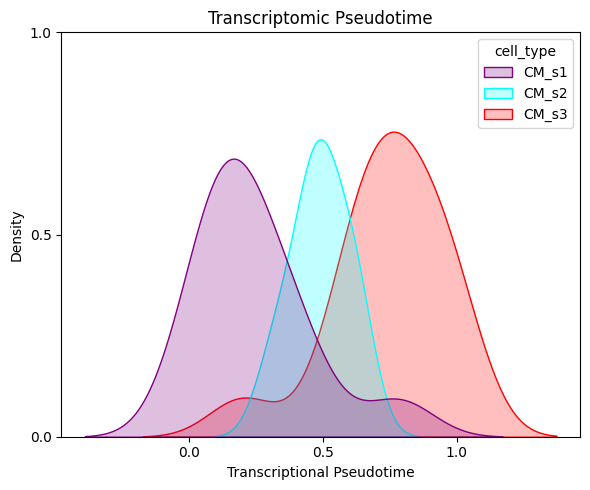

In [17]:
# Extract the transcriptional pseudotime values
trancript_pseudotime = sc_ad_recorded.obs['slingshot_pseudotime_normalized']  

# Extract the cell types from the .obs DataFrame
cell_types = sc_ad_recorded.obs['cell_type']

# Define color palette for each cell type (you can change these colors as you like)
palette = {'CM_s1': 'purple', 'CM_s2': 'cyan', 'CM_s3': 'red'}

# Plot 
plt.figure(figsize=(6, 5))

plt.subplot(1, 1, 1)
sns.kdeplot(x=trancript_pseudotime, hue=cell_types, palette=palette, fill=True)


plt.xlabel('Transcriptional Pseudotime')
plt.ylabel('Density')
plt.xticks([0, 0.5, 1])
plt.yticks([0,0.5,1])
plt.title('Transcriptomic Pseudotime')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


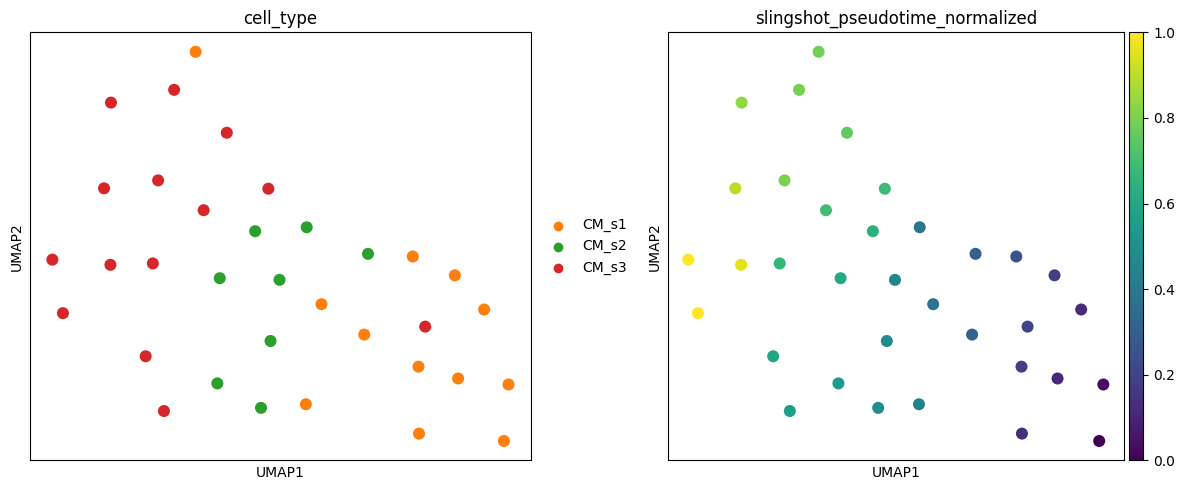

In [18]:
palette = {'CM_s1': '#ff7f0e', 'CM_s2': '#2ca02c', 'CM_s3': '#d62728'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))  

axs1 = sc.pl.umap(sc_ad_recorded, color=['cell_type'], size=300, palette= palette, ax=ax[0], show=False) 
axs2 = sc.pl.umap(sc_ad_recorded, color=['slingshot_pseudotime_normalized'], size=300, ax=ax[1], show=False) 

plt.tight_layout()
plt.show()